# Imports

In [69]:
import os
import time

In [70]:
import numpy as np
import matplotlib.pyplot as plt

In [71]:
!pip install tensorflow

In [72]:
import tensorflow as tf
from keras import layers, Model, Sequential, callbacks, losses, optimizers, datasets

In [73]:
import warnings
from IPython import display
warnings.simplefilter("ignore")

# Vars

In [ ]:
LATENT_DIM = int(10e2)
BATCH_SIZE = 2**5
BUFFER_SIZE = 100000
EPOCHS = 100

# Data Loading

In [75]:
(train_images, train_labels), (_, _) = datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images) / 255

train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
)

In [76]:
train_images.shape

(60000, 28, 28, 1)

# Generator

In [ ]:
class Generator(Model):
    """
    Генератор Keras. Принимает тензор размерности (batch_size, LATENT_DIM)

    Цель - генерировать изображения, неотличимые от настоящих цифр MNIST
    """

    def __init__(self):
        super(Generator, self).__init__()

        # Последовательность слоев
        self.dense_blocks = Sequential(
            [
                layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(LATENT_DIM,)),
                layers.BatchNormalization(),
                layers.ReLU(),

                layers.Reshape((7, 7, 256)),

                layers.Conv2DTranspose(
                    128, (5, 5), strides=(1, 1), padding="same", use_bias=False
                ),
                layers.BatchNormalization(),
                layers.ReLU(),

                layers.Conv2DTranspose(
                    64, (5, 5), strides=(2, 2), padding="same", use_bias=False
                ),
                layers.BatchNormalization(),
                layers.ReLU(),

                layers.Conv2DTranspose(
                    1,
                    (5, 5),
                    strides=(2, 2),
                    padding="same",
                    use_bias=False,
                    activation="sigmoid",
                ),
            ]
        )

    def call(self, inputs):
        return self.dense_blocks(inputs)

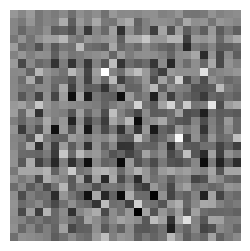

In [78]:
def draw_image(image, image_shape):

    plt.figure(figsize=(3, 3))
    if image_shape[-1] == 1:  # Градации серого
        plt.imshow(image[0, :, :, 0], cmap="gray")
    else:  # RGB или другие форматы
        plt.imshow((image[0] * 255).astype(np.uint8))
    plt.axis("off")
    plt.show()



# Создание экземпляра генератора

generator = Generator()

noise = tf.random.normal([1, LATENT_DIM])
generated_image = generator(noise, training=False)
draw_image(generated_image, generated_image.shape)

# Discriminator

In [79]:
class Discriminator(Model):
    """
    Дискриминатор Keras. Принимает тензор размерности (batch_size, 784)
    и возвращает тензор размерности (batch_size, 1) с вероятностями принадлежности
    к реальным данным
    """

    def __init__(self):
        super(Discriminator, self).__init__()

        self.dense_blocks = Sequential(
            [
                layers.Conv2D(
                    64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]
                ),
                layers.ReLU(),
                layers.Dropout(0.3),
                layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"),
                layers.ReLU(),
                layers.Dropout(0.3),
                layers.Flatten(),
                layers.Dense(1),
            ]
        )

    def call(self, inputs):
        return self.dense_blocks(inputs)

In [80]:
discriminator = Discriminator()
decision = discriminator(generated_image)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.02023958]], dtype=float32)>

# GAN

In [81]:
class GANMonitor(callbacks.Callback):
    def __init__(self, gan_model, test_noise):
        super().__init__()
        self.gan = gan_model
        self.test_noise = test_noise
        self.test_progression = []

    def on_epoch_end(self, epoch, logs=None):
        # Генерация и сохранение изображений
        generated_images = self.gan.generator(self.test_noise)
        self.test_progression.append(generated_images.numpy())

In [ ]:
class GAN(Model):
    def __init__(self):
        super(GAN, self).__init__()
        self.generator = Generator()
        self.discriminator = Discriminator()

    def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, real_images):
        noise = tf.random.normal((BATCH_SIZE, LATENT_DIM))

        # Используем self-модели вместо глобальных переменных
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(noise, training=True)

            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)

            g_loss = self.g_loss(fake_output)
            d_loss = self.d_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )
        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )

        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, self.generator.trainable_variables)
        )
        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, self.discriminator.trainable_variables)
        )

        return {"d_loss": d_loss, "g_loss": g_loss}

# Funcs

In [83]:
def generate_and_save_images(model, epoch, test_input, path):
    predictions = model(test_input)

    fig = plt.figure(figsize=(7, 7))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap="gray")
        plt.axis("off")

    plt.savefig(os.path.join(path, "image_at_epoch_{:04d}.png".format(epoch)))
    plt.show()

In [84]:
cross_entropy = losses.BinaryCrossentropy(from_logits=True)


def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


generator_optimizer = optimizers.Adam(learning_rate=0.0002)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0002)

In [85]:
checkpoint_dir = "./checkpoints"
img_dir = "./images"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator,
)

# Test

In [86]:
SEED = tf.random.normal([16, LATENT_DIM])

In [87]:
def train(model, dataset, epochs):
    count_batches = len(dataset)
    print(f"total epochs: {epochs}")
    print()
    for epoch in range(epochs):
        print(f"epoch {epoch + 1} / {epochs}")

        # start = time.time()

        for index_batch, image_batch in enumerate(dataset):
            print(f"{index_batch + 1} / {count_batches}")
            model.train_step(image_batch)

        display.clear_output(wait=True)
        generate_and_save_images(model.generator, epoch + 1, SEED, img_dir)

        if (epoch + 1) % 5 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # print (f'Time for epoch {epoch + 1} is {time.time() - start} sec')
    print()

    # display.clear_output(wait=True)
    generate_and_save_images(model.generator, epochs, SEED, img_dir)

In [ ]:
gan = GAN()
gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss,
)

In [89]:
train(gan, train_dataset, EPOCHS)

discriminator.save("models/discriminator.keras")
generator.save("models/generator.keras")

TypeError: TensorFlowTrainer.predict() got an unexpected keyword argument 'training'

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

draw_image(generated_image, generated_image.shape)